# CellRank2 Analysis for Rebulttal Letter

CellRank2 analysis of 
* TE001 using CellRank2 CytoTRACE-Based Kernel
* TE001 using CellRank2 VIPER-Based Kernel
* TE006 using CellRank2 CytoTRACE-Based Kernel
* TE006 using CellRank2 VIPER-Based Kernel

All showing initial and terminal states

### A) Import packages and data

Setup path to data-containing folder and savings and parameters

In [31]:
input_data_path = "/Users/av2729/Clouds/DropBox/isc-data-at-cell/input/"
figures_dir = "/Users/av2729/Clouds/DropBox/isc-data-at-cell/figures/"

n_macro_CytoTRACE = 8 # number of macrostates 

Import packages and set markers of interest

In [43]:
import sys
import cellrank as cr
from VIPERKernel import VIPERKernel
import scanpy as sc
import numpy as np
import pandas as pd
import os
from matplotlib import rc_context
import matplotlib.pyplot as plt
sc.settings.set_figure_params(frameon=False, dpi=100)
cr.settings.verbosity = 2

sc.settings.figdir = figures_dir 
cr.settings.figdir = figures_dir 

import scvelo as scv
scv.settings.figdir = figures_dir 

import warnings
warnings.simplefilter("ignore", category=UserWarning)

cytotrace_markers = ['Smarca5','Rbbp7','Tcerg1','Hnrnpd','Hmg20b','Nelfe','Ube2i','Etv5','Ubn1','Mbd3','Dek','Maz',
                     'Itgb3bp','Ilf2','Pa2g4'] # Id3','Hnf4g','Atoh1','Spdef','Neurod1' markers upregulated in cytotrace (Fig 1e) 

### Load VIPER data and Metadata and Setup UMAP coordinates for WT (TE001)

In [15]:
WT_viper_filename = input_data_path + "TE001-subnetworks-one-signature-seurat-viper-analysis-with-metacell-data-with-paneth.h5ad"
vp_adata_wt = sc.read_h5ad(WT_viper_filename)
WT_metadata_csv = input_data_path + "TE001-metadata-umap-and-clusters-for-paper.csv"
vp_metadata_wt = pd.read_csv(WT_metadata_csv)

specified_columns = ["cell_id", "nCount_VIPER", "nFeature_VIPER", "mt_percent", "cytotrace_score.ges",
                     "seurat_clusters", "singleR_labels"]

vp_adata_wt.obs = vp_adata_wt.obs[specified_columns]
cells_to_analyze = vp_metadata_wt['cell_id'] # cells to analyze
vp_adata_wt = vp_adata_wt[vp_adata_wt.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

vp_adata_wt.obs = pd.merge(vp_adata_wt.obs, vp_metadata_wt, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

# vp_adata_wt.obs['seurat_clusters'] = vp_adata_wt.obs['seurat_clusters'].astype('category') # VIPER clusters as categorical variable

# Set up UMAP coordinates to those obtained at protein activty
umap_coordinates = np.array(vp_adata_wt.obs.loc[:, ['UMAP_1_scanpy','UMAP_2_scanpy']]) 
vp_adata_wt.obsm['X_umap'] = umap_coordinates

# Include metadata of terminal states for CellRank analysis
vp_adata_wt.obs['terminal_states'] = vp_adata_wt.obs['iter_cluster_id_with_paneth']
vp_adata_wt.obs['terminal_states'].iloc[vp_adata_wt.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

### Load VIPER data and Metadata and Setup UMAP coordinates for Ablation (TE006)

In [20]:
abl_viper_filename = input_data_path + "TE006-viper.h5ad"
vp_adata_abl = sc.read_h5ad(abl_viper_filename)

abl_metadata_csv = input_data_path + "TE006-metadata-ingest-with-cluster-ids-with-paneth-cluster.csv"
vp_metadata_abl = pd.read_csv(abl_metadata_csv)

specified_columns = ["cell_id", "nCount_VIPER", "nFeature_VIPER", "cytotrace_score_ges",
                     "seurat_clusters", "singleR_labels",
                     'UMAP_1.PAS.with_seurat','UMAP_2.PAS.with_seurat',
                     'UMAP_1.PAS','UMAP_2.PAS']

vp_adata_abl.obs = vp_adata_abl.obs[specified_columns]
cells_to_analyze = vp_metadata_abl['index'] # cells to analyze
vp_metadata_abl = vp_metadata_abl.rename(columns={"index": "cell_id"})
vp_adata_abl = vp_adata_abl[vp_adata_abl.obs_names.isin(cells_to_analyze)] # subset cells to analyze in adata

vp_adata_abl.obs = pd.merge(vp_adata_abl.obs, vp_metadata_abl, on='cell_id', how='left').set_index('cell_id') # merge metadata and include into counts object

# vp_adata_abl.obs['seurat_clusters'] = vp_adata_abl.obs['seurat_clusters'].astype('category') # VIPER clusters as categorical variable

# a.6) set UMAP coordinates to those obtained at protein activty
# umap_coordinates = np.array(adata.obs.loc[:, ['UMAP_1.PAS.with_seurat','UMAP_2.PAS.with_seurat']]) # Strange results
umap_coordinates = np.array(vp_adata_abl.obs.loc[:, ['UMAP_1.PAS','UMAP_2.PAS']]) 
vp_adata_abl.obsm['X_umap'] = umap_coordinates

# a.7) Include metadata of terminal states for CellRank analysis
vp_adata_abl.obs['terminal_states'] = vp_adata_abl.obs['iter_cluster_id_with_paneth']
vp_adata_abl.obs['terminal_states'].iloc[vp_adata_abl.obs['terminal_states'].isin(["stem-1","stem-2"])] = np.nan

ablation_metadata_csv = input_data_path + "ablation-metadata-ingest.csv"
ablation_metadata = pd.read_csv(ablation_metadata_csv)
vp_adata_abl.obs = pd.merge(vp_adata_abl.obs, ablation_metadata, on='cell_id', how='left').set_index('cell_id')
umap_coordinates = np.array(vp_adata_abl.obs.loc[:, ['UMAP_1','UMAP_2']]) 
vp_adata_abl.obsm['X_umap'] = umap_coordinates
vp_adata_abl.obs = pd.merge(vp_adata_abl.obs, ablation_metadata, on='cell_id', how='left').set_index('cell_id')

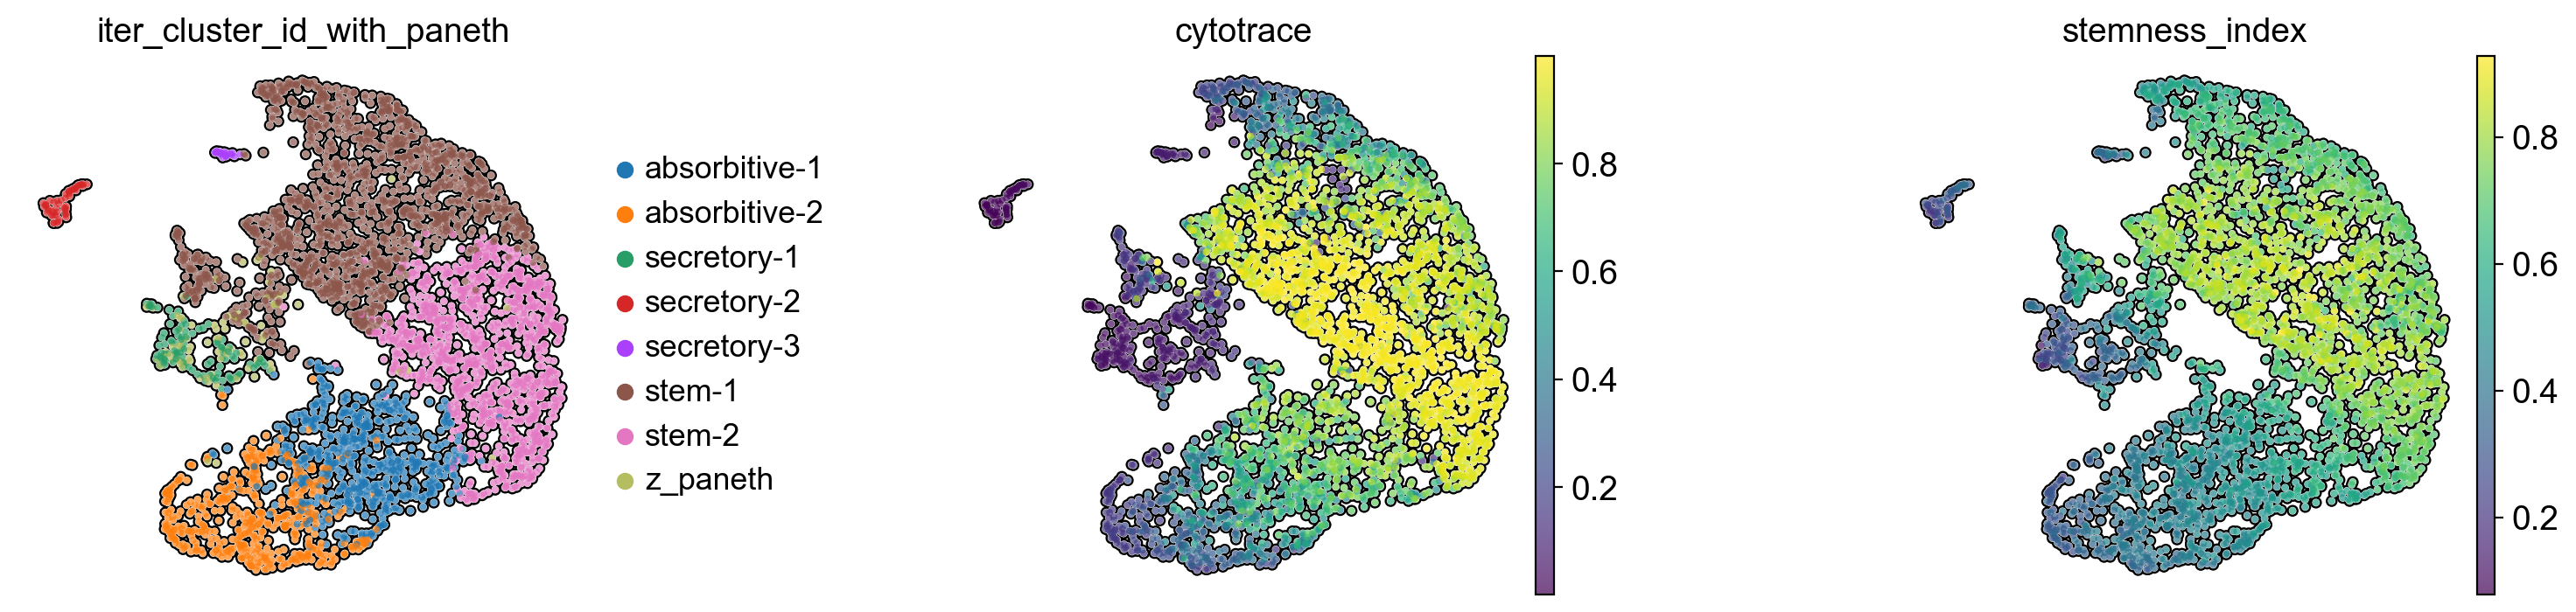

In [57]:
sc.pl.umap(vp_adata_wt, color=["iter_cluster_id_with_paneth","cytotrace","stemness_index"], 
           ncols=3, add_outline=True , wspace=0.5 , save="-TE001-VIPER-UMAP.pdf")

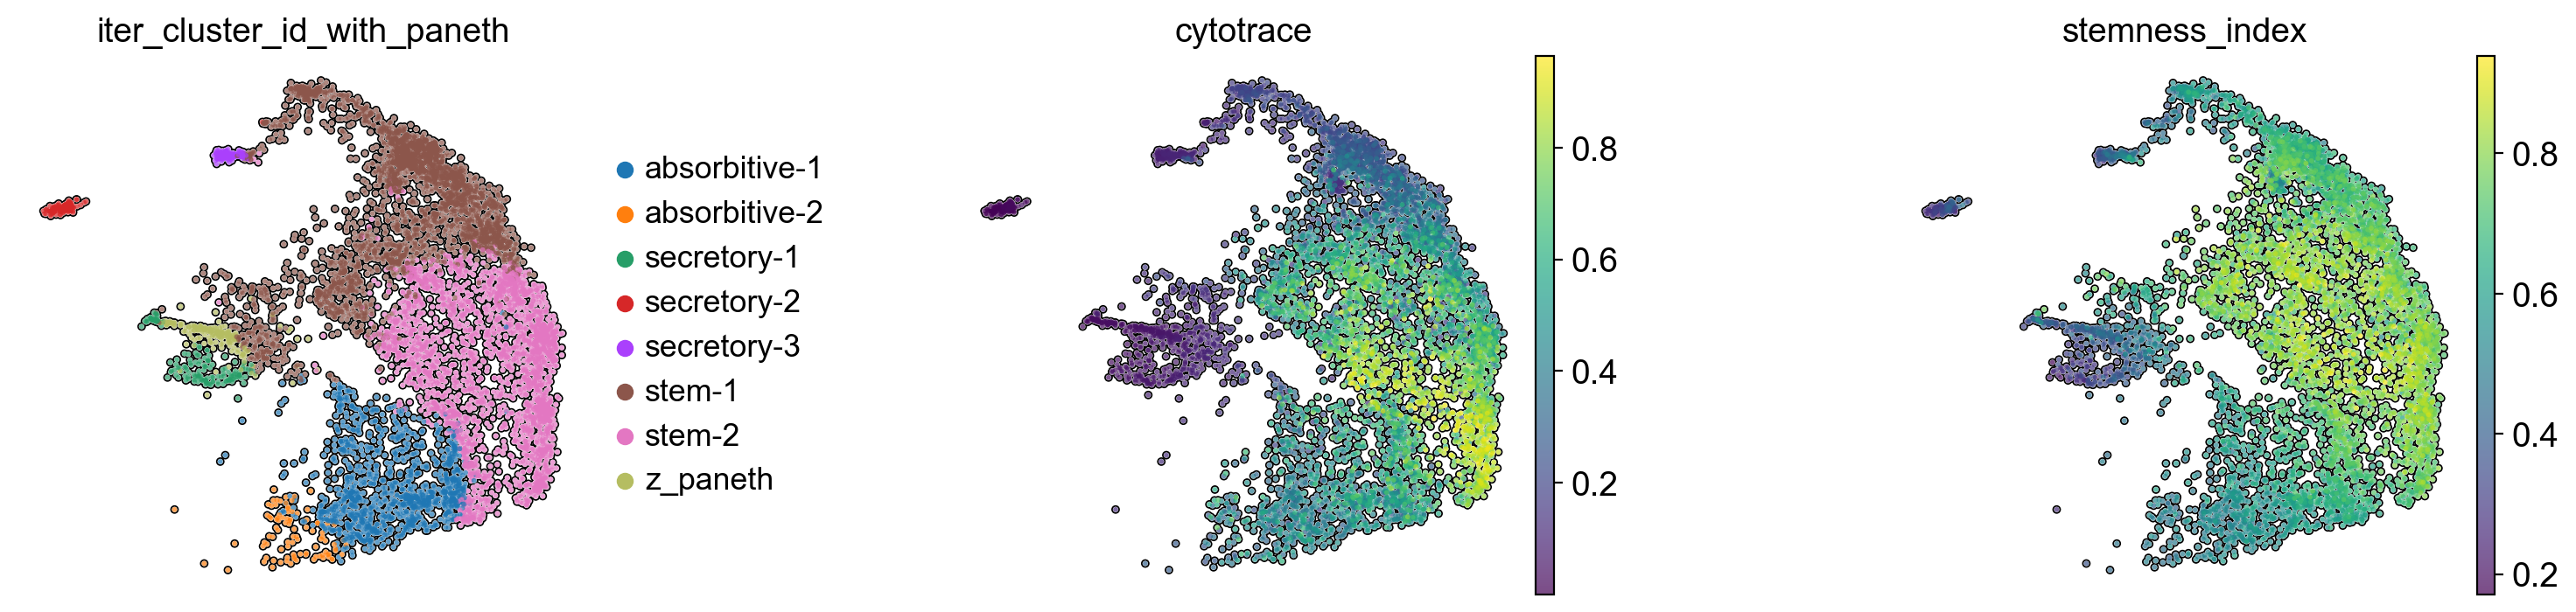

In [34]:
sc.pl.umap(vp_adata_abl, color=["iter_cluster_id_with_paneth","cytotrace","stemness_index"], 
           ncols=3, add_outline=True , wspace=0.5 , save="-TE006-VIPER-UMAP.pdf")

### Preprocess data for CellRank2 analysis

In [35]:
sc.tl.pca(vp_adata_wt, random_state=0)
sc.pp.neighbors(vp_adata_wt, random_state=0)

sc.tl.pca(vp_adata_abl, random_state=0)
sc.pp.neighbors(vp_adata_abl, random_state=0)

## CellRank2 analysis with VIPER-kernel

### Compute transition matrix using our VIPER-based kernel for CellRank2 analysis

In [36]:
vpk_wt = VIPERKernel(vp_adata_wt)
vpk_abl = VIPERKernel(vp_adata_abl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6977/6977 [00:14<00:00, 466.04it/s]


Compute VIPER-based transition matrix and use it to create a kernel

Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/av2729/Clouds/DropBox/isc-data-at-cell/figures/scvelo_-TE001-VIPERKernel-vector-fields.svg


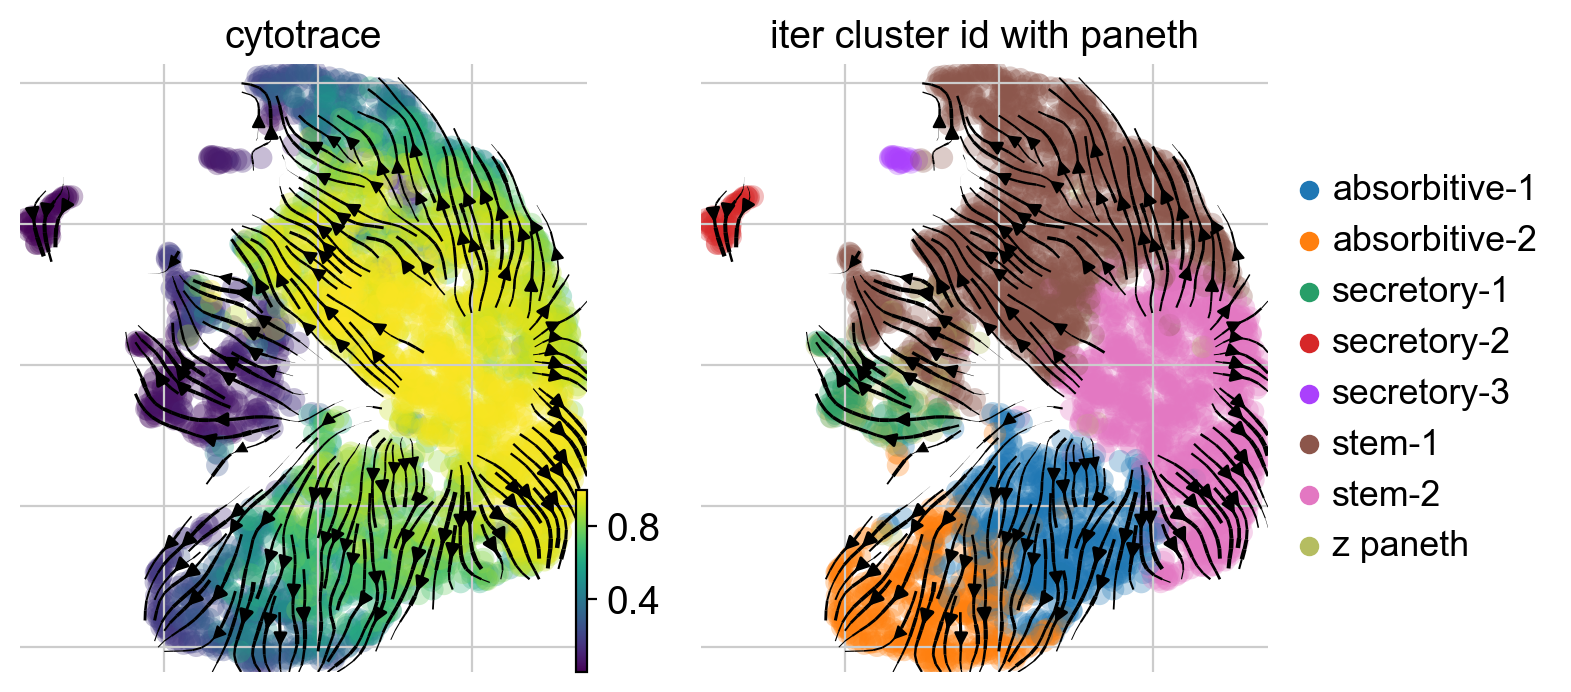

In [53]:
vpk_wt.plot_projection(basis="umap",
                    color = ["cytotrace","iter_cluster_id_with_paneth"], wspace = 1 ,
                    legend_loc="right", save="-TE001-VIPERKernel-vector-fields.svg", show=True)


Using precomputed projection `adata.obsm['T_fwd_umap']`
saving figure to file /Users/av2729/Clouds/DropBox/isc-data-at-cell/figures/scvelo_-TE006-VIPERKernel-vector-fields.svg


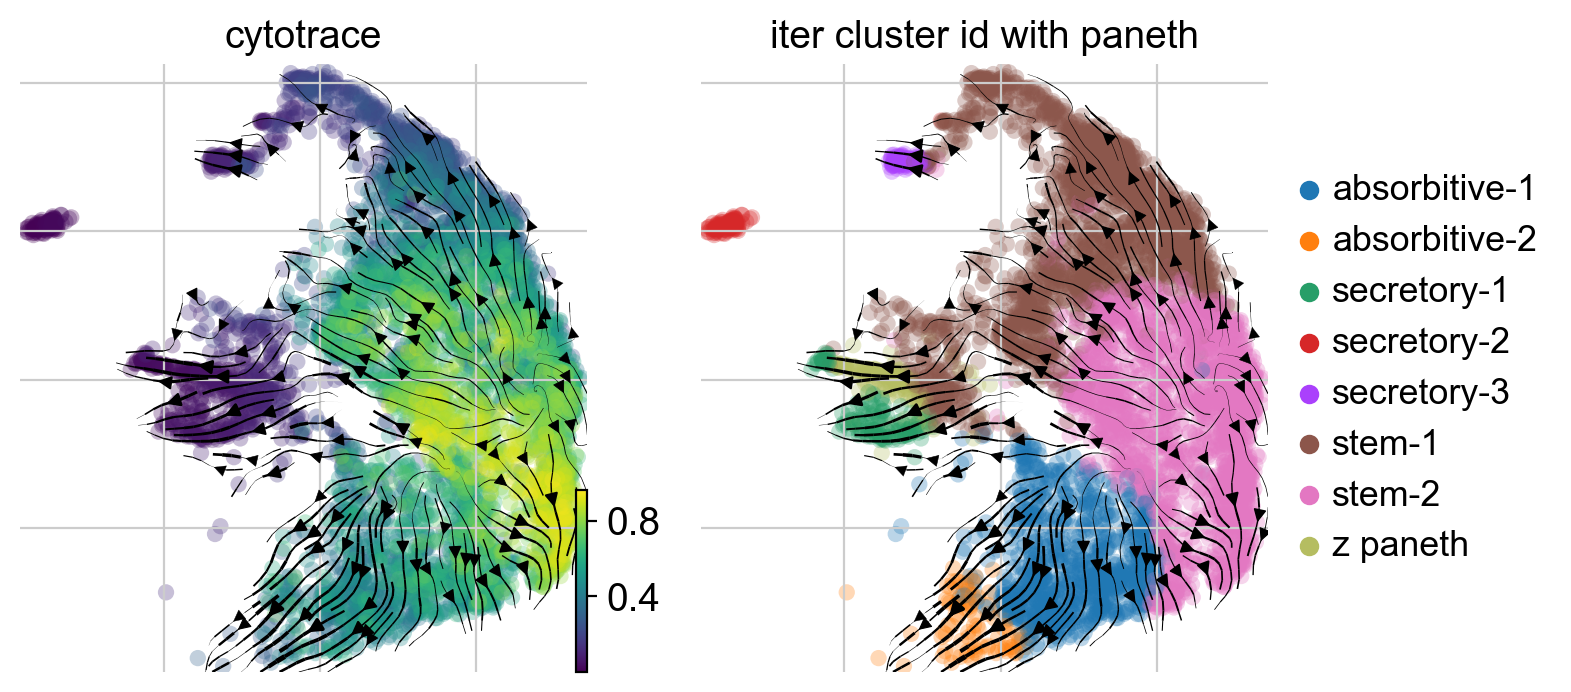

In [54]:
vpk_abl.plot_projection(basis="umap",
                    color = ["cytotrace","iter_cluster_id_with_paneth"], wspace = 1 ,
                    legend_loc="right", save="-TE006-VIPERKernel-vector-fields.svg", show=True)


### Determination of initial and terminal states

CellRank 2 (advanced) estimator-baed analysis of the Transition Matrix and calculation of the terminal states. Show the real value of the eigenvalues from Schur's decomposition (Figure 1), cell-type distrbution of the terminal states (Figure 2) and visualization of the coarse-grain transition matrix (Figure 3). To change the number of selected macrostate, change n_macro_CytoTRACE in the first cell of this notebook.

Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[12, 27, 33, 66, 74, 76, 78, 86, 89, 91, 94, 96, 98]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:07)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:02)
saving figure to file /Users/av2729/Clouds/DropBox/isc-data-at-cell/figures/scvelo_-TE001-GPCCA-macrostates.pdf


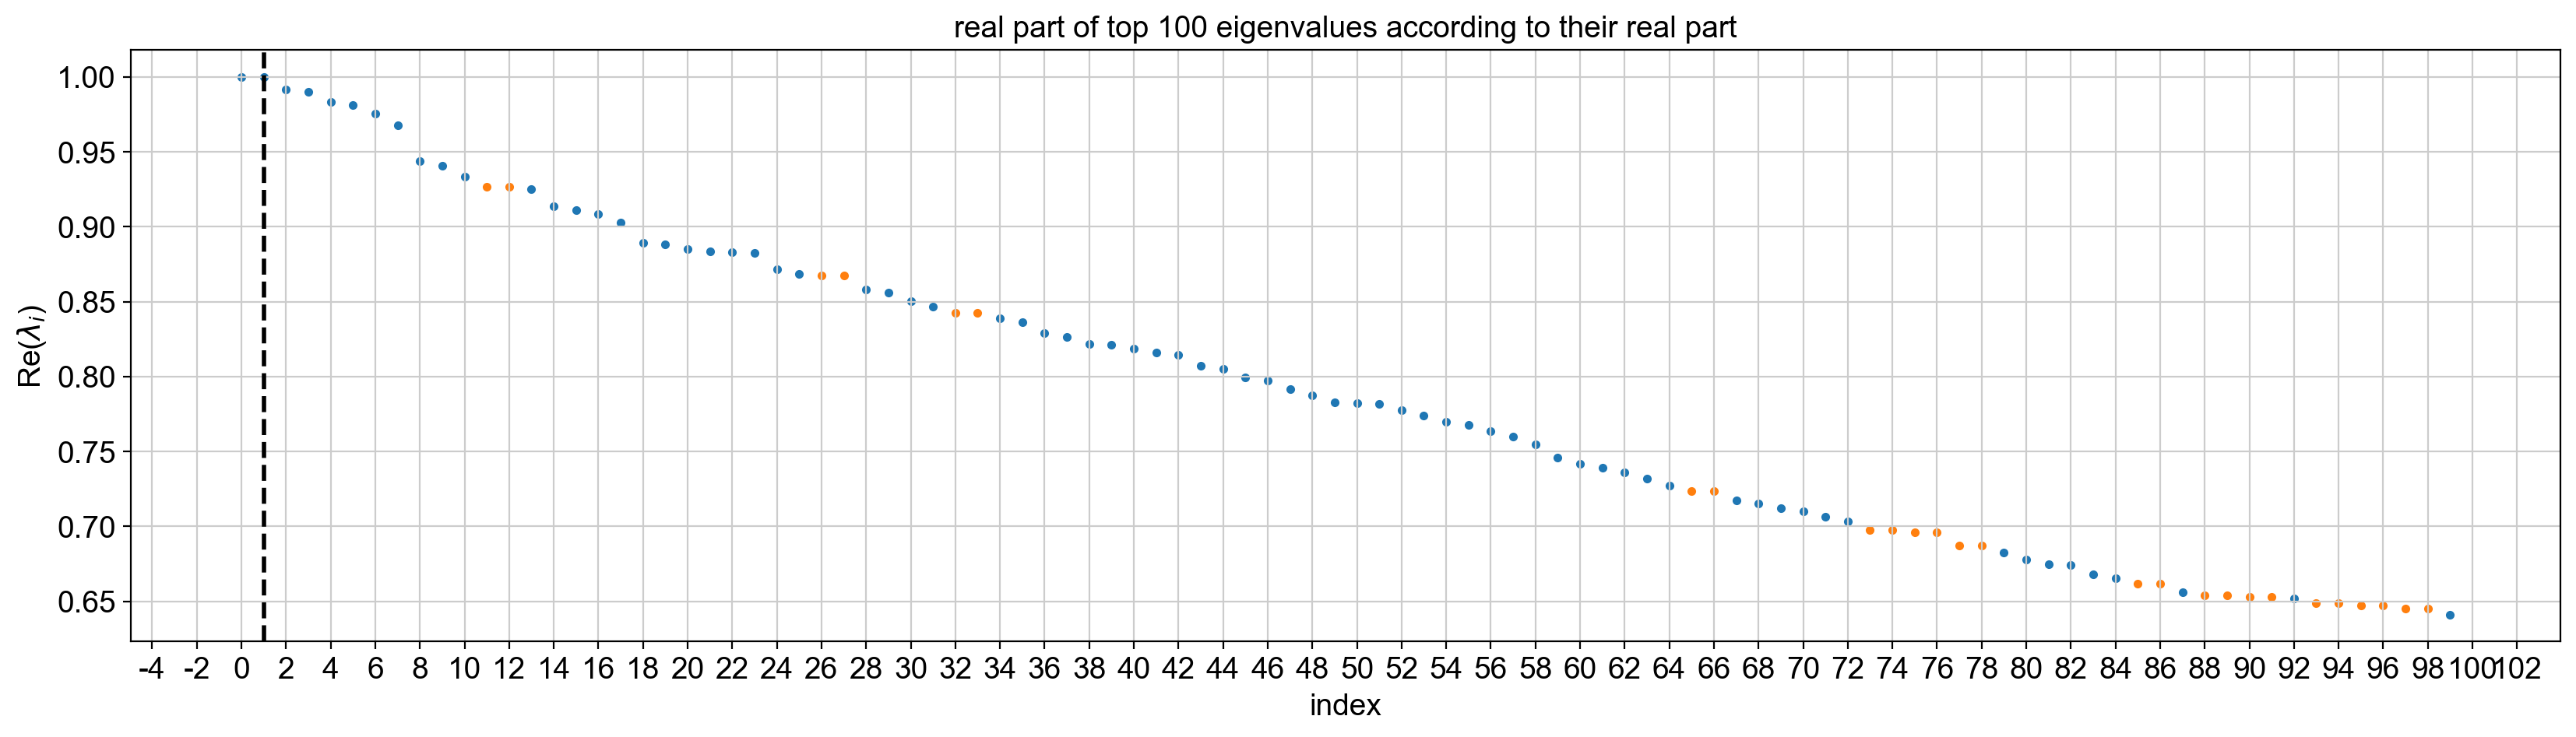

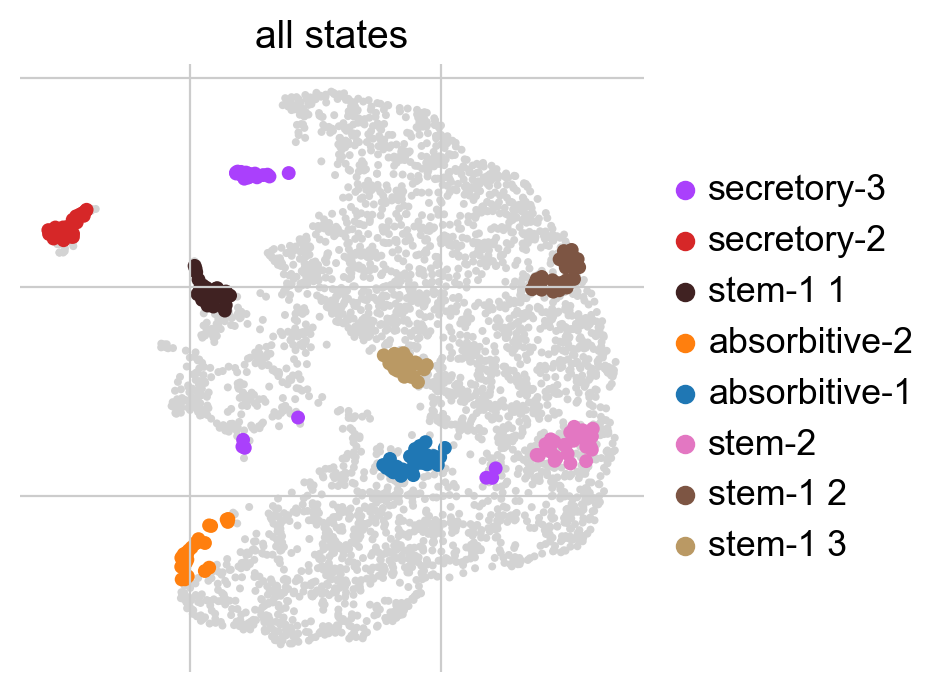

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
saving figure to file /Users/av2729/Clouds/DropBox/isc-data-at-cell/figures/scvelo_-TE001-GPCCA_terminal_states.pdf


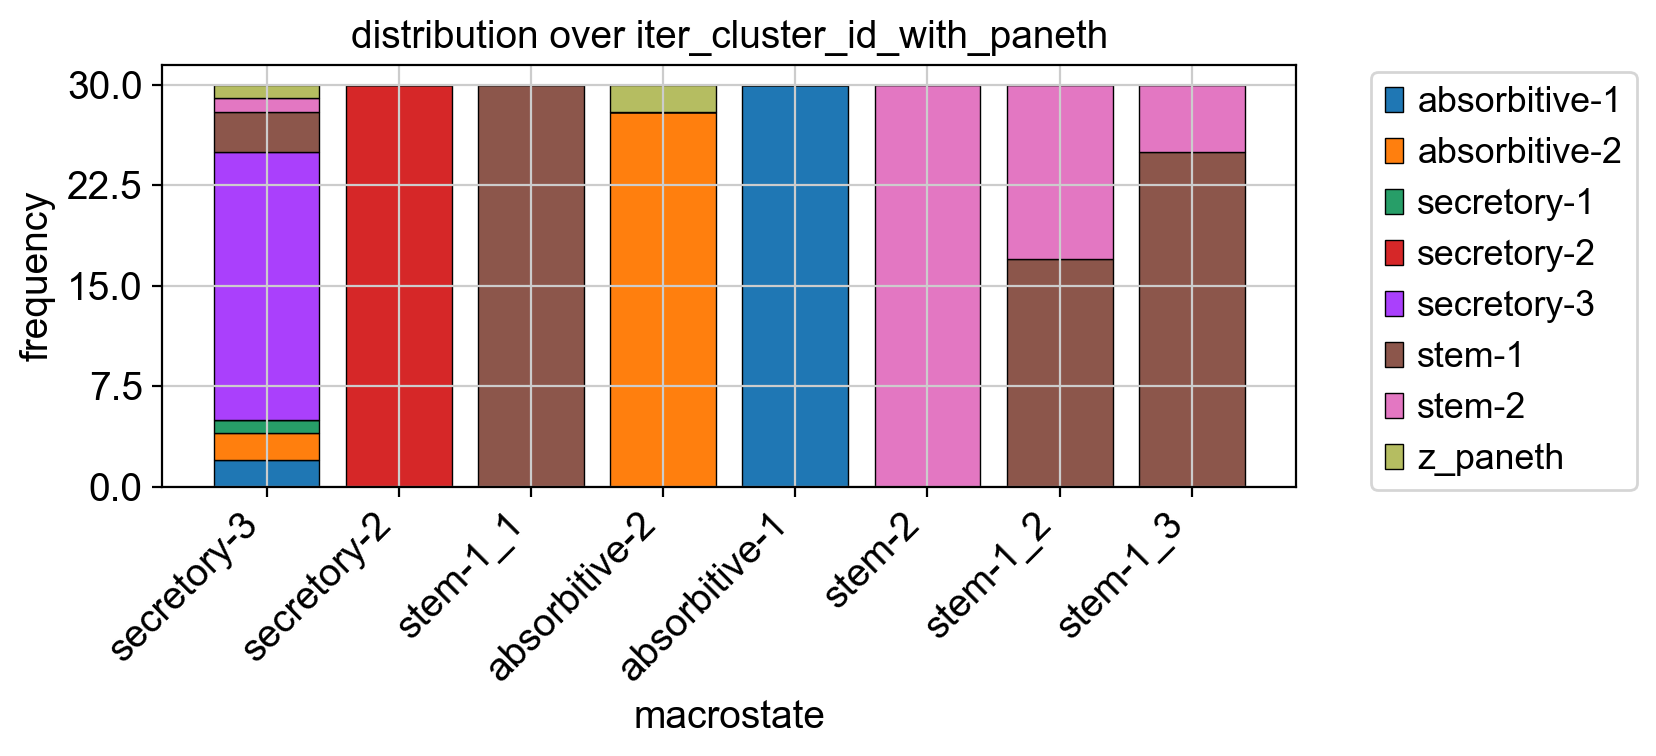

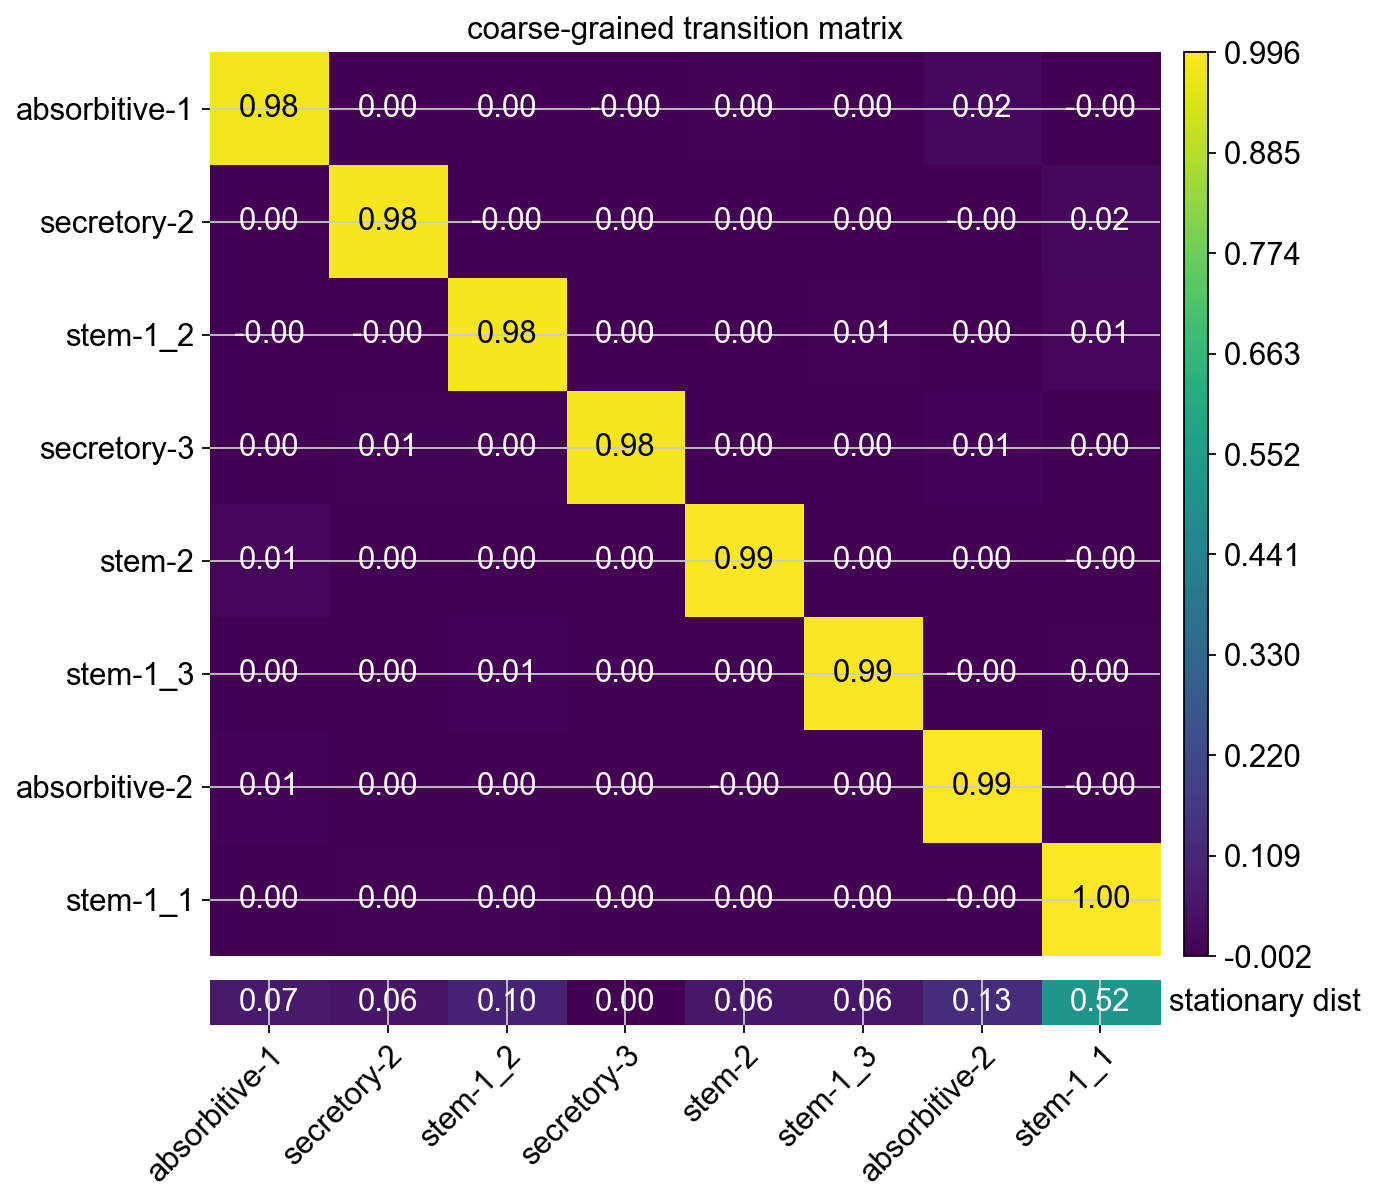

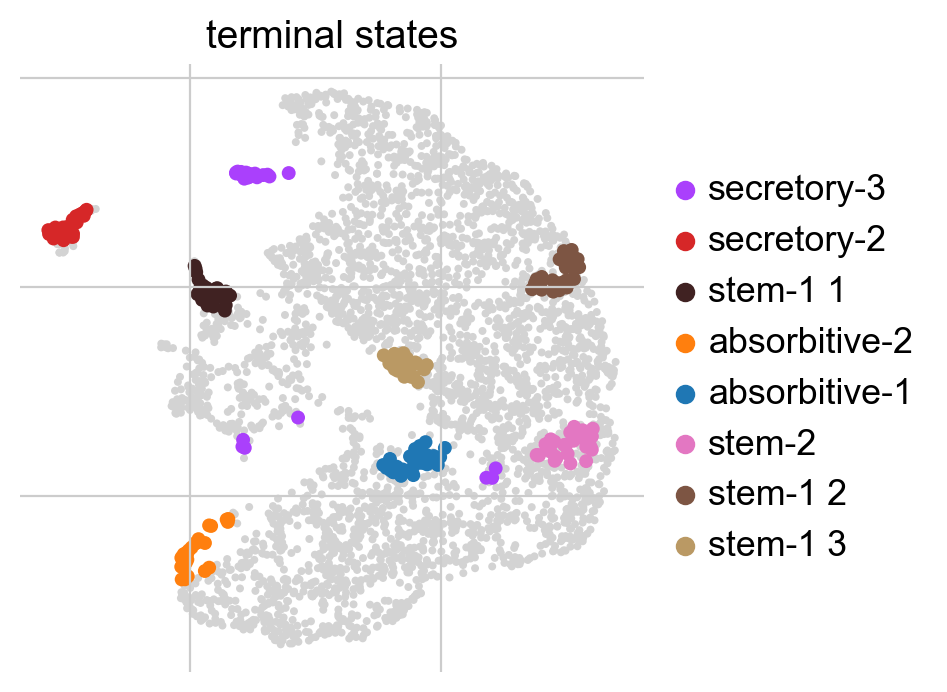

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`
saving figure to file /Users/av2729/Clouds/DropBox/isc-data-at-cell/figures/scvelo_-TE001-GPCCA_initial_states.pdf


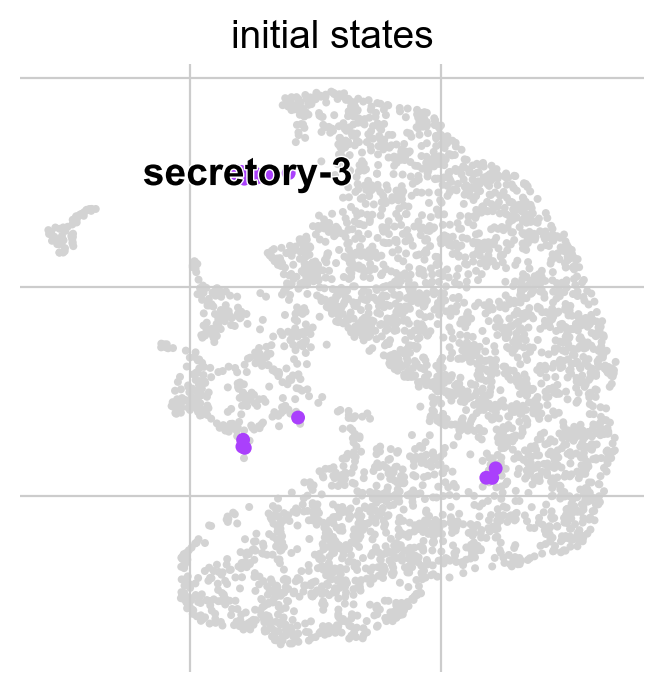

In [60]:
# Advanced estimator-based analysis of the VIPER-kernel with estimators 
from cellrank.estimators import GPCCA
from cellrank.estimators import CFLARE

# compute estimator
est_vpk_wt = cr.estimators.GPCCA(vpk_wt)
est_vpk_wt.compute_schur(n_components=100) # compute Schur decomposition
est_vpk_wt.plot_spectrum(real_only=True, n=None, show_all_xticks=False, save="-TE001-GPCCA_eig.pdf", figsize=(20,5))

est_vpk_wt.compute_macrostates(n_states=n_macro_CytoTRACE, cluster_key="iter_cluster_id_with_paneth")
est_vpk_wt.plot_macrostates(which="all", legend_loc="right", s=100, save="-TE001-GPCCA-macrostates.pdf", show=True)

est_vpk_wt.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=True, 
                                      save="-TE001-GPCCA_macrostates_composition.pdf") # composition of each macrostate

est_vpk_wt.plot_coarse_T(annotate=True, save="-TE001-GPCCA_coarse_T.pdf") # plot transition matrix

# compute terminal states
est_vpk_wt.predict_terminal_states()
est_vpk_wt.plot_macrostates(which="terminal", legend_loc="right", s=100, save="-TE001-GPCCA_terminal_states.pdf", show=True)

# predict initial states
est_vpk_wt.predict_initial_states(allow_overlap=True)
est_vpk_wt.plot_macrostates(which="initial", s=100, save = "-TE001-GPCCA_initial_states.pdf", show = True)


Compute a score based on the expression of the `cytotrace_markers` defined in the second cell of this notebook.

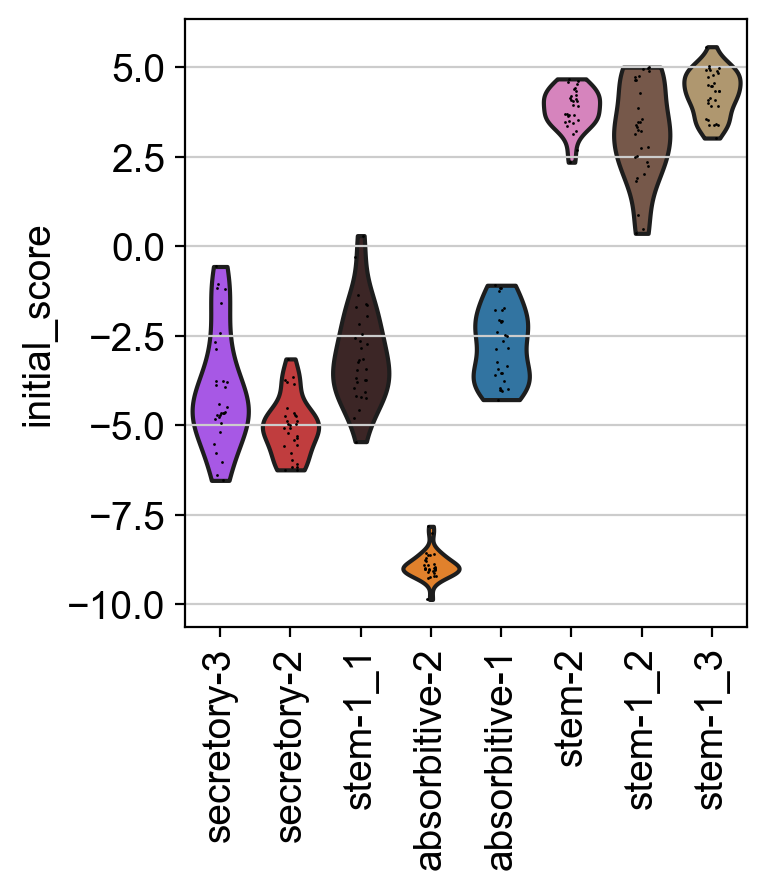

In [14]:
# d.4) verify the initial score by aggregating across cytotrace markers

sc.tl.score_genes(
    adata, gene_list=cytotrace_markers, score_name="initial_score", use_raw=False
) # compute a score in scanpy by aggregating across a few cytotrace markers
# collect macrostates to AnnData
adata.obs["macrostates"] = g_vpk.macrostates 
adata.uns["macrostates_colors"] = g_vpk.macrostates_memberships.colors
# visualize macrostates via initial_scores
sc.pl.violin(adata, keys="initial_score", groupby="macrostates", rotation=90)


Collect the inferred terminal states in a list for ease of manipulation.

In [15]:
inferred_terminal_states = g_vpk.terminal_states.unique().dropna().to_list()

Estimate Fate probabilities towards the identified terminal states

Computing fate probabilities
Defaulting to `'gmres'` solver.


  0%|          | 0/8 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/Fate_probability.pdf


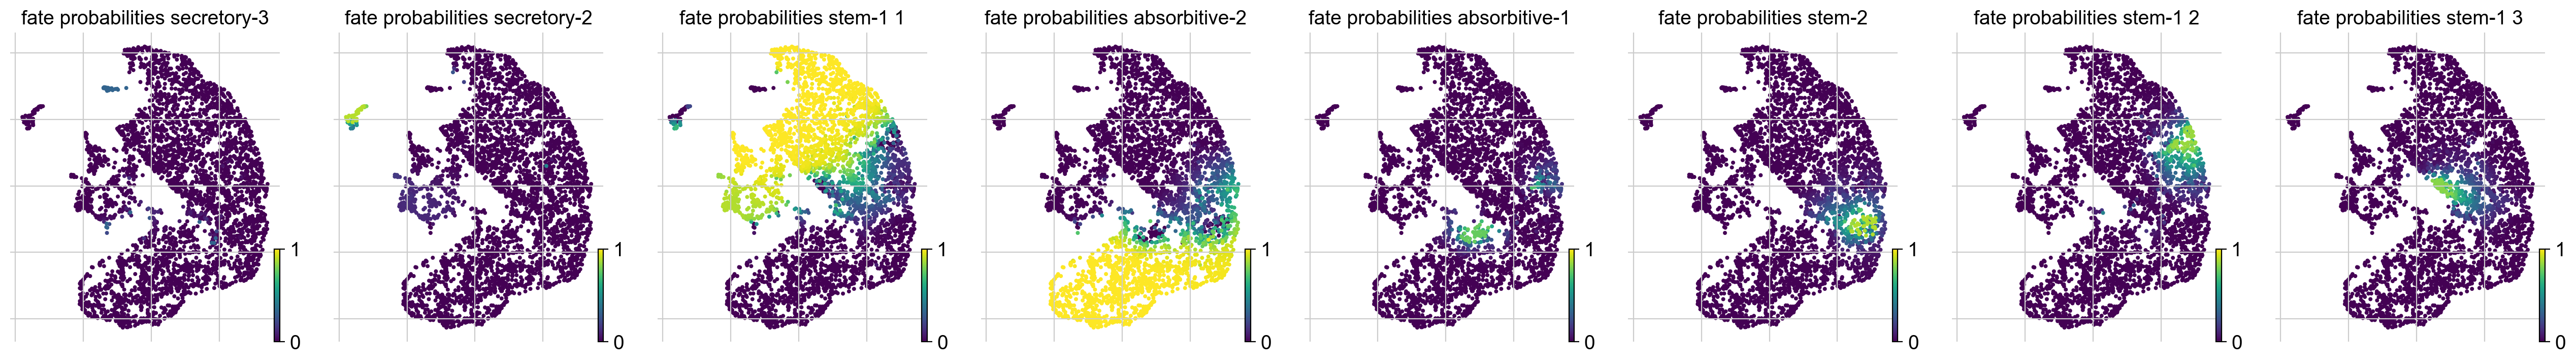

In [16]:
#########################################################
# f) Estimating Fate Probabilities 

# f.1) compute fate probabilities towards identified terminal states
g_vpk.compute_fate_probabilities()

# f.2) visualize fate probabilities on UMAP
fate_probability_figure = figures_dir_TE001 + "Fate_probability.pdf"
g_vpk.plot_fate_probabilities(same_plot=False, vmax=1,show=True, save=fate_probability_figure)

# # f.3) visualize fate probabilities on a circular projection
# fate_circular_figure = figures_dir_TE001 + "Fate_circular.pdf"
# cr.pl.circular_projection(adata, keys="iter_cluster_id_with_paneth", legend_loc="right", save=fate_circular_figure)

# # fate_circular_figure = figures_dir_TE001 + "Fate_circular_genes.pdf"
# # cr.pl.circular_projection(adata, keys=["log(Lgr4)", "log(Lgr5)", "log(Atad2)", "log(Mki67)"], cmap = "Oranges", ncols=2, legend_loc="right", save=fate_circular_figure)

# # f.4) aggregate fate probabilities and visualize how they are committed towards selected cell types   
# progenitor_states = ["stem-1", "stem-2"] # select stem-1 and stem-2 as the progenitor states to aggregate their probabilities
# fate_committed_vln_figure = figures_dir_TE001 + "Fate_committed_vln.pdf"
# cr.pl.aggregate_fate_probabilities(
#     adata,
#     mode="violin",
#     lineages=inferred_terminal_states,
#     cluster_key="iter_cluster_id_with_paneth",
#     clusters=progenitor_states,
#     save=fate_committed_vln_figure
# )

Computing `2` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
saving figure to file /Users/AlexanderWang/Desktop/ics-rebuttal/figures/CR2_VIPERKernel/TE001/GPCCA_macrostates.pdf


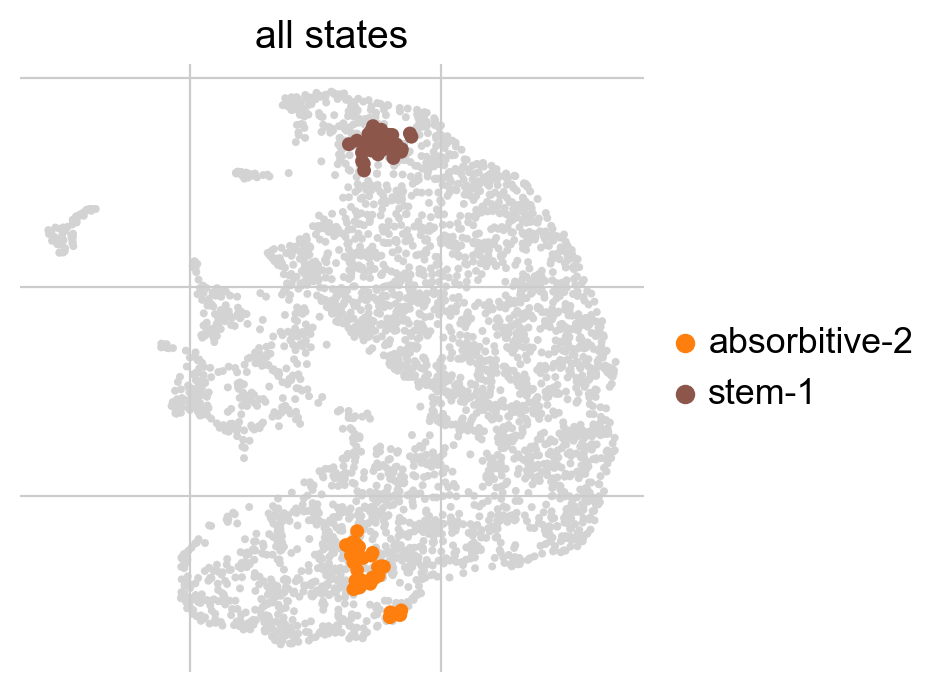

Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


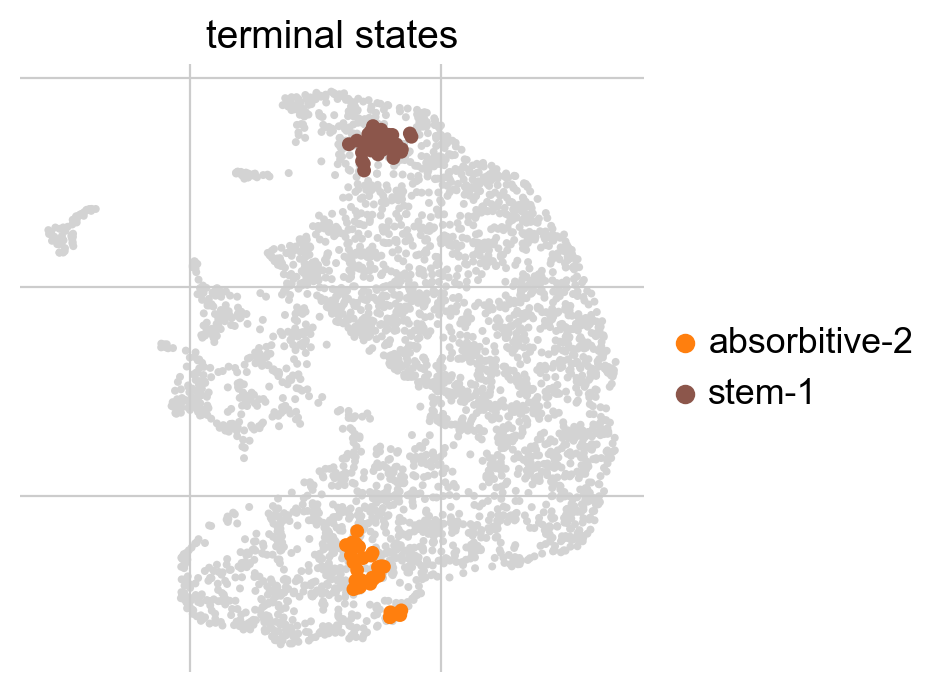

Adding `adata.obs['init_states_fwd']`
       `adata.obs['init_states_fwd_probs']`
       `.initial_states`
       `.initial_states_probabilities`
       `.initial_states_memberships
    Finish`


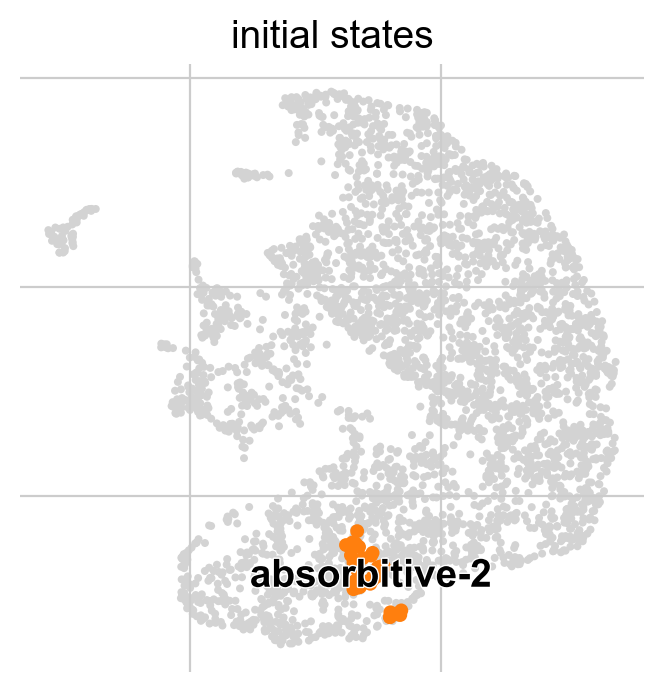

In [17]:
# Using default values
g_vpk.compute_macrostates(cluster_key="iter_cluster_id_with_paneth")
g_vpk.plot_macrostates(which="all", legend_loc="right", s=100)#, save=macrostates_figure, show=True)

# macrostates_figure_composition = figures_dir_TE006 + "GPCCA_macrostates_composition.pdf"
# g_vpk.plot_macrostate_composition(key="iter_cluster_id_with_paneth", figsize=(8.5,4), show=True, save=macrostates_figure_composition) # composition of each macrostate

# coarse_T_figure = figures_dir_TE006 + "GPCCA_coarse_T.pdf"
# g_vpk.plot_coarse_T(annotate=True, save=coarse_T_figure) # plot transition matrix

# d.2) compute terminal states
g_vpk.predict_terminal_states()
# terminal_states_figure = figures_dir_TE006 + "GPCCA_terminal_states.pdf"
g_vpk.plot_macrostates(which="terminal", legend_loc="right", s=100)#, save=terminal_states_figure, show=True)

# d.3) predict initial states
g_vpk.predict_initial_states(allow_overlap=True)
# initial_states_figure = figures_dir_TE006 + "GPCCA_initial_states.pdf"
g_vpk.plot_macrostates(which="initial", s=100)#, save=initial_states_figure, show=True)
